# Data preparation/exploration for the Aguathon

## Problem definition

Find the best model that predict the level of the Evro river when cros Zaragoza.

----

## Index

1. [Import modules and Data](#first-bullet)
2. [Data exploration](#second-bullet)
3. [Feature Engineering](#third-bullet)
4. [Feature selection](#fourth-bullet)
5. [Missing Values](#fifth-bullet)
   * Split the data in train and test set
6. [Model regressor](#sixth-bullet)
    * Cross-validation

## Import modules and Data <a class="anchor" id="first-bullet"></a>

In [1]:
%load_ext autoreload
%matplotlib inline
#%matplotlib notebook
%autoreload 1


# STD lib imports
import os
import sys

# Third party libs
import xgboost
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
from xgboost import plot_importance

# sklear stuff
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_squared_error as ecm
from sklearn.metrics import r2_score as r2
from sklearn.preprocessing import PolynomialFeatures

import warnings
warnings.filterwarnings('ignore')

# root path of the project
PROJ_ROOT = os.path.join(os.pardir)

# add the 'src' directory as one where we can import modules
src_dir = os.path.join(PROJ_ROOT, 'src')
sys.path.append(src_dir)

# import my method from the source code
%aimport data.make_dataset
%aimport features.build_features
%aimport visualization.visualize
import data.make_dataset as md
import features.build_features as bf
import visualization.visualize as vs

os.environ['KMP_DUPLICATE_LIB_OK']='True'

print(os.path.abspath(PROJ_ROOT))

# Load data from ITA
raw_file = 'datos.csv'
path = '../ENTRADA/'
df_raw = md.load_data(path, raw_file)

# choose columns
cols = []

# period of the data
start = df_raw.index.min()
end = df_raw.index.max()

idx = df_raw.resample('D').mean().index

print('Shape:', df_raw.shape)
display(df_raw.head())

/Users/miloc/Documents/git-hub/Apsu
Shape: (95856, 10)


,ALAGON_NR,GRISEN_NR,NOVILLAS_NR,TAUSTE_NR,TUDELA_NR,ZGZ_NR,RIESGO,pred_24h,pred_48h,pred_72h
time,,,,,,,,,,
2008-01-01 00:00:00,0.8100,0.4375,1.6000,0.2675,0.7875,0.74,False,0.750,0.7400,0.76
2008-01-01 01:00:00,0.8100,0.4725,1.6075,0.2650,0.7900,0.74,False,0.745,0.7325,0.76
2008-01-01 02:00:00,0.8100,0.5425,1.6100,0.2675,0.7900,0.74,False,0.740,0.7300,0.76
2008-01-01 03:00:00,0.8075,0.5500,1.6100,0.2600,0.7900,0.74,False,0.740,0.7200,0.76
2008-01-01 04:00:00,0.8000,0.5525,1.6025,0.2650,0.7900,0.74,False,0.740,0.7200,0.76


In [2]:
# Estation to load data
estaciones = {'pna': '9262-19530901-20190131.csv',  
              'zar_aero':'9434-19410101-20190302.csv'}

# inputs
cols = ['FECHA','TMEDIA','TMIN','TMAX','PRECIPITACION']
path_meteo = '../data/AEMET/DatosPorEstacion/'

# Load meteo data and filter by period
df_meteo = md.load_meteo(path_meteo, estaciones, cols) 
    
# complete hourly data
df_meteo = df_meteo.resample('H').ffill()/24

# Filter by period
df_meteo = df_meteo[(df_meteo.index >= start) & (df_meteo.index <= end)]

print('Shape:', df_meteo.shape)
display(df_meteo.tail())

Shape: (95856, 8)


,TMEDIA_pna,TMIN_pna,TMAX_pna,PRECIPITACION_pna,TMEDIA_zar_aero,TMIN_zar_aero,TMAX_zar_aero,PRECIPITACION_zar_aero
FECHA,,,,,,,,
2018-12-07 19:00:00,NaN,0.033333,NaN,0.491667,0.383333,0.0,0.170833,0.6
2018-12-07 20:00:00,NaN,0.033333,NaN,0.491667,0.383333,0.0,0.170833,0.6
2018-12-07 21:00:00,NaN,0.033333,NaN,0.491667,0.383333,0.0,0.170833,0.6
2018-12-07 22:00:00,NaN,0.033333,NaN,0.491667,0.383333,0.0,0.170833,0.6
2018-12-07 23:00:00,NaN,0.033333,NaN,0.491667,0.383333,0.0,0.170833,0.6


In [7]:
path_ebro = '../data/SAIHEBRO/'
features = ['AFORO', 'PRECIPITACION/']
stations = ['A001', 'A005']
variables = ['NRIO1', 'PACUM']

df_ebro = md.load_ebro(path_ebro, features, stations, variables, start, end)

print('Shape:', df_ebro.shape)
display(df_ebro.head())

Shape: (95856, 7)


,A001-L17-NRIO1_VALOR_MAX,A001-L17-NRIO1_VALOR_MIN,A001-L17-NRIO1_VALOR_MED,A005-E17-NRIO1_VALOR_MAX,A005-E17-NRIO1_VALOR_MIN,A005-E17-NRIO1_VALOR_MED,A005-E84-PACUM_VALOR_MAX
FECHA,,,,,,,
2008-01-01 00:00:00,0.038333,0.029583,0.035417,0.015833,0.014583,0.015417,0.0
2008-01-01 01:00:00,0.038333,0.029583,0.035417,0.015833,0.014583,0.015417,0.0
2008-01-01 02:00:00,0.038333,0.029583,0.035417,0.015833,0.014583,0.015417,0.0
2008-01-01 03:00:00,0.038333,0.029583,0.035417,0.015833,0.014583,0.015417,0.0
2008-01-01 04:00:00,0.038333,0.029583,0.035417,0.015833,0.014583,0.015417,0.0


In [8]:
# Concatenate both data frames
df = pd.concat([df_raw, df_meteo, df_ebro], axis=1)

print('Shape:', df.shape)
display(df.tail())

Shape: (95856, 25)


,ALAGON_NR,GRISEN_NR,NOVILLAS_NR,TAUSTE_NR,TUDELA_NR,ZGZ_NR,RIESGO,pred_24h,pred_48h,pred_72h,...,TMIN_zar_aero,TMAX_zar_aero,PRECIPITACION_zar_aero,A001-L17-NRIO1_VALOR_MAX,A001-L17-NRIO1_VALOR_MIN,A001-L17-NRIO1_VALOR_MED,A005-E17-NRIO1_VALOR_MAX,A005-E17-NRIO1_VALOR_MIN,A005-E17-NRIO1_VALOR_MED,A005-E84-PACUM_VALOR_MAX
FECHA,,,,,,,,,,,,,,,,,,,,,
2018-12-07 19:00:00,0.9850,0.6950,1.7300,0.52,0.8450,1.05,False,1.03,1.0,0.99,...,0.0,0.170833,0.6,0.0375,0.036667,0.037083,0.013333,0.005833,0.011667,0.0
2018-12-07 20:00:00,0.9800,0.6925,1.7475,0.52,0.8450,1.05,False,1.03,1.0,0.99,...,0.0,0.170833,0.6,0.0375,0.036667,0.037083,0.013333,0.005833,0.011667,0.0
2018-12-07 21:00:00,0.9675,0.6925,1.7500,0.52,0.8375,1.05,False,1.03,1.0,0.99,...,0.0,0.170833,0.6,0.0375,0.036667,0.037083,0.013333,0.005833,0.011667,0.0
2018-12-07 22:00:00,0.9550,0.6925,1.7400,0.52,0.8300,1.05,False,1.03,1.0,0.99,...,0.0,0.170833,0.6,0.0375,0.036667,0.037083,0.013333,0.005833,0.011667,0.0
2018-12-07 23:00:00,0.9450,0.6925,1.7375,0.52,0.8300,1.05,False,1.03,1.0,0.99,...,0.0,0.170833,0.6,0.0375,0.036667,0.037083,0.013333,0.005833,0.011667,0.0


In [9]:
df.isnull().sum()

ALAGON_NR                   16968
GRISEN_NR                    8710
NOVILLAS_NR                  1468
TAUSTE_NR                     519
TUDELA_NR                     277
ZGZ_NR                          0
RIESGO                          0
pred_24h                        0
pred_48h                        0
pred_72h                        0
TMEDIA_pna                     48
TMIN_pna                       24
TMAX_pna                       24
PRECIPITACION_pna              24
TMEDIA_zar_aero                 0
TMIN_zar_aero                   0
TMAX_zar_aero                   0
PRECIPITACION_zar_aero          0
A001-L17-NRIO1_VALOR_MAX      168
A001-L17-NRIO1_VALOR_MIN      168
A001-L17-NRIO1_VALOR_MED      168
A005-E17-NRIO1_VALOR_MAX     3648
A005-E17-NRIO1_VALOR_MIN     3648
A005-E17-NRIO1_VALOR_MED     3648
A005-E84-PACUM_VALOR_MAX      264
dtype: int64

## Data exploration <a class="anchor" id="second-bullet"></a>

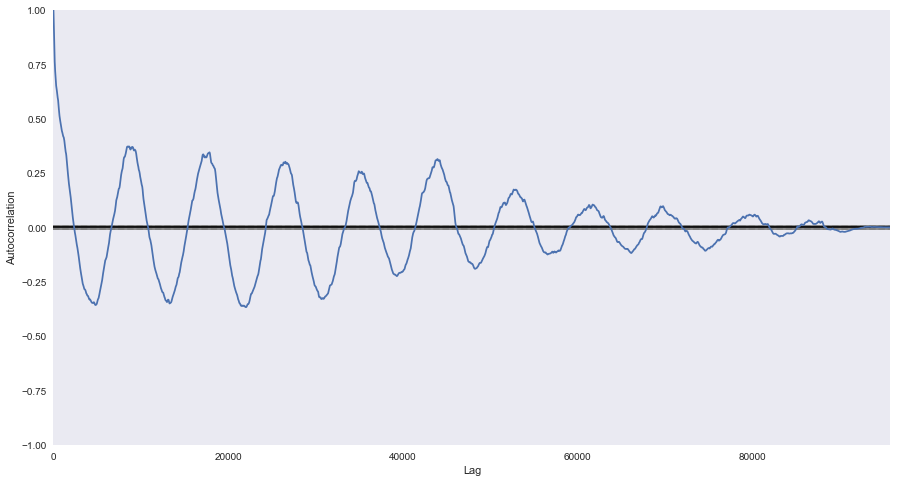

In [5]:
plt.figure(figsize=(15,8))
pd.plotting.autocorrelation_plot(df.NOVILLAS_NR.fillna(0))

(array([2.8175e+04, 6.5440e+03, 5.3100e+03, 3.4870e+03, 1.0292e+04,
        2.0521e+04, 9.9500e+03, 1.8730e+03, 4.0200e+02, 1.1300e+02,
        6.1000e+01, 5.9000e+01, 5.5000e+01, 3.5000e+01, 3.3000e+01,
        2.6000e+01, 3.5000e+01, 1.3000e+01, 1.2000e+01, 1.1000e+01,
        1.2000e+01, 1.1000e+01, 1.2000e+01, 7.0000e+00, 7.0000e+00,
        1.0000e+01, 8.0000e+00, 5.0000e+00, 6.0000e+00, 5.0000e+00,
        8.0000e+00, 1.7000e+01, 3.0000e+00, 2.0000e+00, 1.0000e+00,
        3.0000e+00, 2.0000e+00, 4.0000e+00, 5.0000e+00, 1.1000e+01]),
 array([0.07    , 0.170125, 0.27025 , 0.370375, 0.4705  , 0.570625,
        0.67075 , 0.770875, 0.871   , 0.971125, 1.07125 , 1.171375,
        1.2715  , 1.371625, 1.47175 , 1.571875, 1.672   , 1.772125,
        1.87225 , 1.972375, 2.0725  , 2.172625, 2.27275 , 2.372875,
        2.473   , 2.573125, 2.67325 , 2.773375, 2.8735  , 2.973625,
        3.07375 , 3.173875, 3.274   , 3.374125, 3.47425 , 3.574375,
        3.6745  , 3.774625, 3.87475 , 3.974875

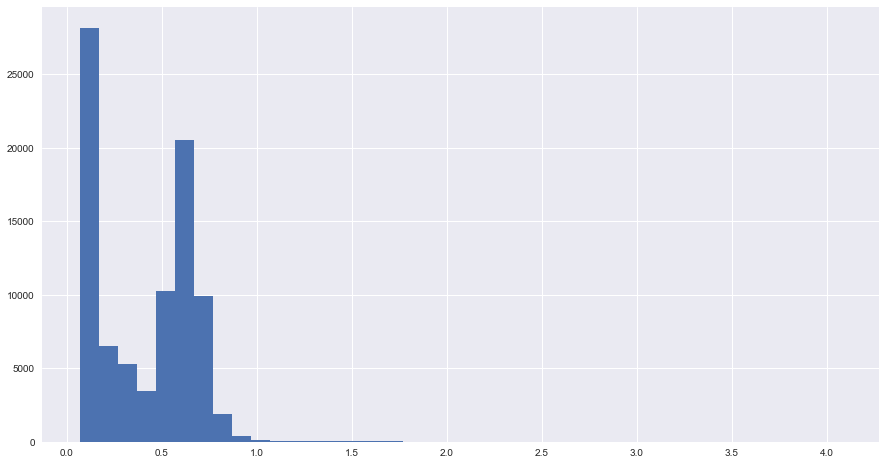

In [6]:
# histogram
plt.figure(figsize=(15,8))
plt.hist(df.GRISEN_NR.values, 40)

In [10]:
df = df.drop(['GRISEN_NR'], axis=1)

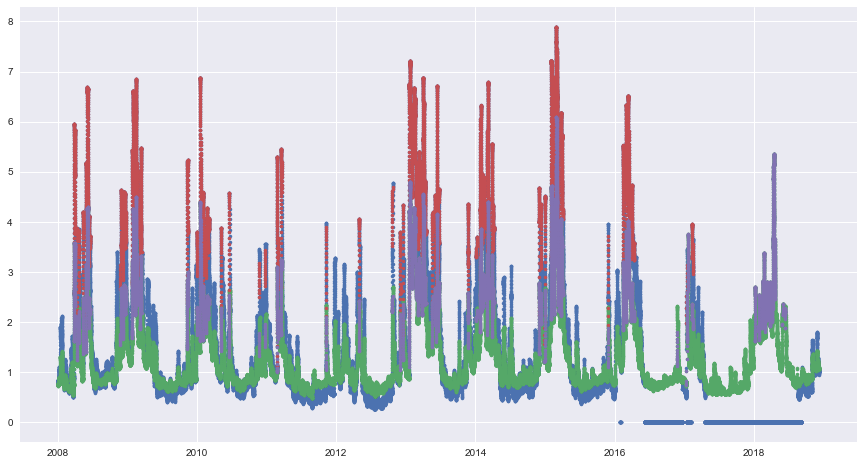

In [8]:
plt.figure(figsize=(15,8))
plt.plot(df.ALAGON_NR.fillna(0), '.')
plt.plot(df.ZGZ_NR.fillna(0), '.')
plt.plot(df[df.RIESGO==1].ALAGON_NR, '.')
plt.plot(df[df.RIESGO==1].ZGZ_NR, '.')

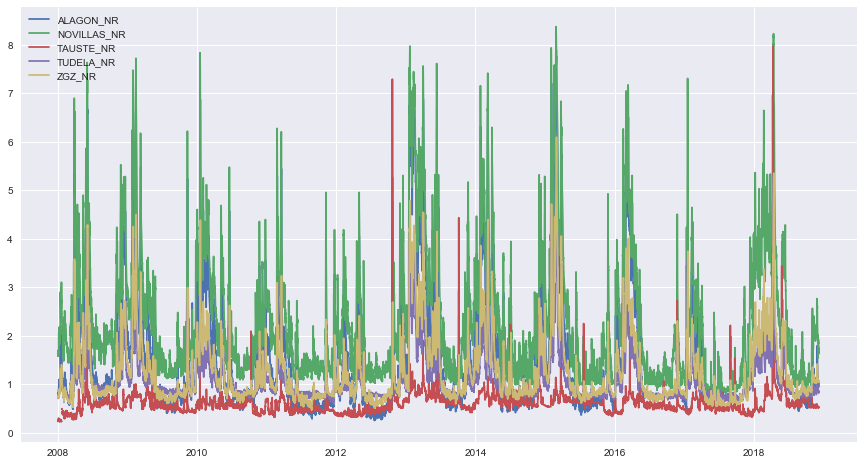

In [9]:
df.iloc[:,:5].plot(figsize=(15,8))

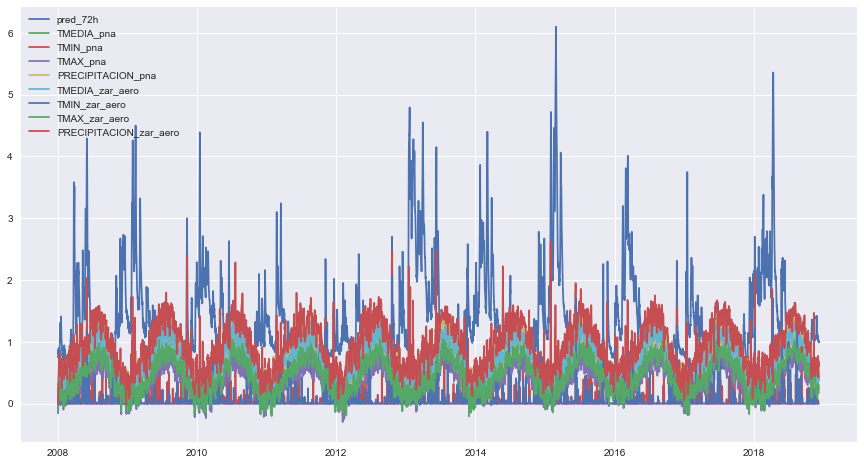

In [10]:
df.iloc[:,8:].plot(figsize=(15,8))

(array([3.7850e+03, 3.8529e+04, 1.7367e+04, 9.0290e+03, 5.7900e+03,
        4.1030e+03, 3.4730e+03, 2.8820e+03, 2.1650e+03, 1.5470e+03,
        1.2690e+03, 1.1130e+03, 8.7300e+02, 5.5700e+02, 3.4900e+02,
        3.5700e+02, 3.5200e+02, 2.1900e+02, 2.7500e+02, 2.4800e+02,
        3.0000e+02, 1.9800e+02, 1.9200e+02, 1.2300e+02, 1.0600e+02,
        8.1000e+01, 4.0000e+01, 3.2000e+01, 5.0000e+01, 4.3000e+01,
        2.9000e+01, 1.0000e+01, 1.2000e+01, 1.0000e+01, 1.6000e+01,
        9.0000e+00, 6.0000e+00, 1.1000e+01, 1.7000e+01, 1.2000e+01]),
 array([0.6075, 0.7385, 0.8695, 1.0005, 1.1315, 1.2625, 1.3935, 1.5245,
        1.6555, 1.7865, 1.9175, 2.0485, 2.1795, 2.3105, 2.4415, 2.5725,
        2.7035, 2.8345, 2.9655, 3.0965, 3.2275, 3.3585, 3.4895, 3.6205,
        3.7515, 3.8825, 4.0135, 4.1445, 4.2755, 4.4065, 4.5375, 4.6685,
        4.7995, 4.9305, 5.0615, 5.1925, 5.3235, 5.4545, 5.5855, 5.7165,
        5.8475]),
 <a list of 40 Patch objects>)

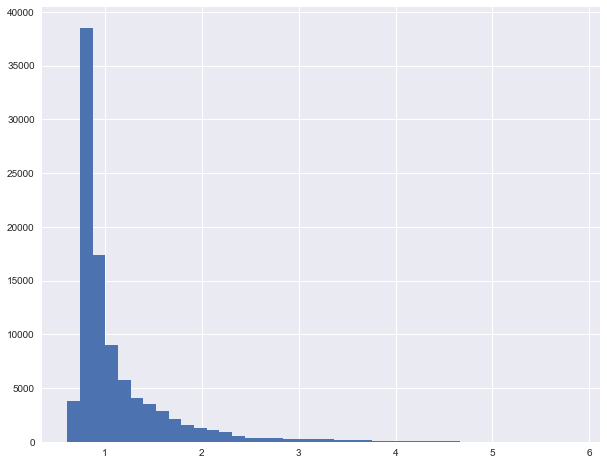

In [11]:
plt.figure(figsize=(10,8))
plt.hist(df.TUDELA_NR.values, 40)

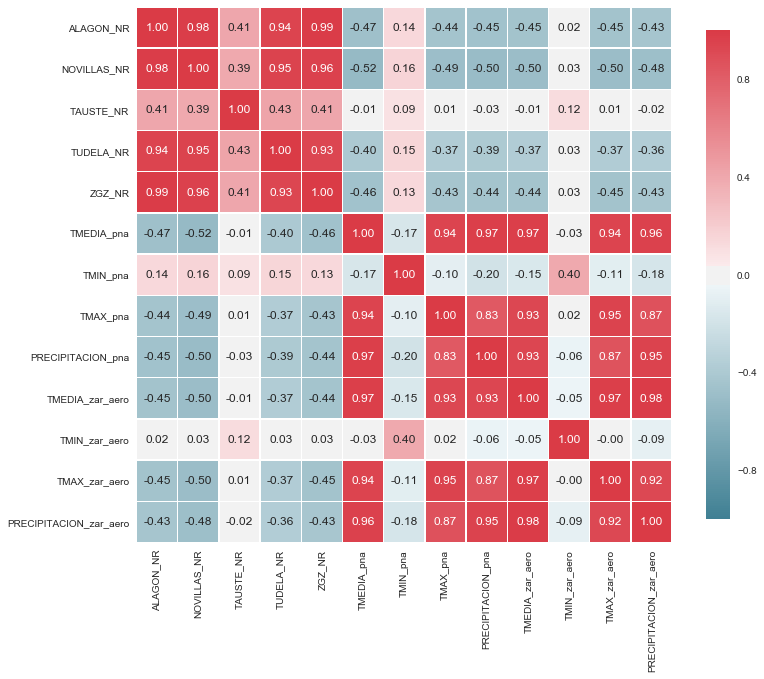

In [12]:
vs.corr_heatmap(pd.concat([df.iloc[:,:5], df.iloc[:,9:]], axis=1))

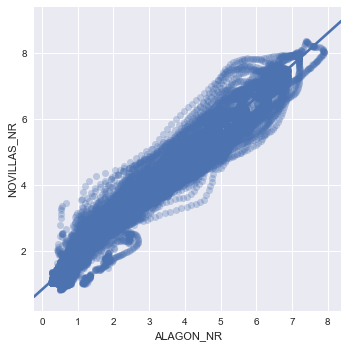

In [13]:
sns.lmplot(x='ALAGON_NR', y='NOVILLAS_NR', data=df, palette='Set1', scatter_kws={'alpha':0.3})
plt.show()

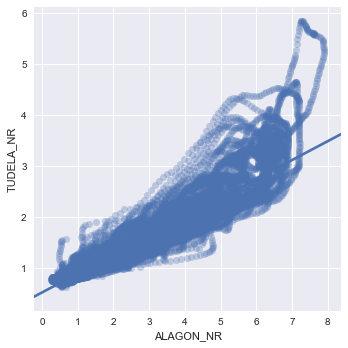

In [14]:
sns.lmplot(x='ALAGON_NR', y='TUDELA_NR', data=df, palette='Set1', scatter_kws={'alpha':0.3})
plt.show()

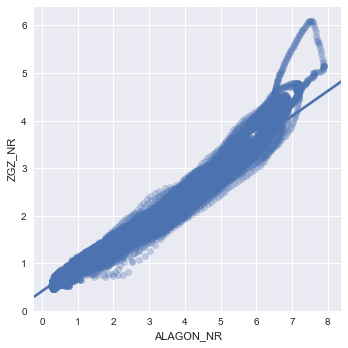

In [15]:
sns.lmplot(x='ALAGON_NR', y='ZGZ_NR', data=df, palette='Set1', scatter_kws={'alpha':0.3})
plt.show()

In [11]:
df.columns

Index(['ALAGON_NR', 'NOVILLAS_NR', 'TAUSTE_NR', 'TUDELA_NR', 'ZGZ_NR',
       'RIESGO', 'pred_24h', 'pred_48h', 'pred_72h', 'TMEDIA_pna', 'TMIN_pna',
       'TMAX_pna', 'PRECIPITACION_pna', 'TMEDIA_zar_aero', 'TMIN_zar_aero',
       'TMAX_zar_aero', 'PRECIPITACION_zar_aero', 'A001-L17-NRIO1_VALOR_MAX',
       'A001-L17-NRIO1_VALOR_MIN', 'A001-L17-NRIO1_VALOR_MED',
       'A005-E17-NRIO1_VALOR_MAX', 'A005-E17-NRIO1_VALOR_MIN',
       'A005-E17-NRIO1_VALOR_MED', 'A005-E84-PACUM_VALOR_MAX'],
      dtype='object')

In [12]:
RIESGO = df['RIESGO']
df = df.drop(['RIESGO'], axis=1)

## Feature engineering <a class="anchor" id="third-bullet"></a>

In [13]:
# Features
columns_y = ['pred_24h', 'pred_48h', 'pred_72h']
columns_x = [x for x in df.columns if x not in columns_y]

X = df[columns_x]
Y = df[columns_y[2]]

# Create features base on delta to time
cols_delt = columns_x[:5]
X = bf.delta_height(X, cols_delt, 1, True)
X = bf.delta_height(X, cols_delt, 5, True)

N = 1       # number of derived columns per feature
delta = 8   # time delta in hr
dup_cols = ['TUDELA_NR', 'NOVILLAS_NR']
X = bf.column_shift(X, dup_cols, N, delta)

delta = 145   # time delta in hr
dup_cols = ['ALAGON_NR', 'ZGZ_NR']#, 'Tud', 'Zar']
X = bf.column_shift(X, dup_cols, N, delta) 


print('Shape:', X.shape)
display(X.head())

Shape: (95850, 34)


,ALAGON_NR,NOVILLAS_NR,TAUSTE_NR,TUDELA_NR,ZGZ_NR,TMEDIA_pna,TMIN_pna,TMAX_pna,PRECIPITACION_pna,TMEDIA_zar_aero,...,delta_1_ZGZ_NR,delta_5_ALAGON_NR,delta_5_NOVILLAS_NR,delta_5_TAUSTE_NR,delta_5_TUDELA_NR,delta_5_ZGZ_NR,TUDELA_NR_8,NOVILLAS_NR_8,ALAGON_NR_145,ZGZ_NR_145
FECHA,,,,,,,,,,,,,,,,,,,,,
2008-01-01 06:00:00,0.800,1.590,0.2600,0.7825,0.7425,0.083333,0.0,-0.158333,0.329167,-0.058333,...,-0.0025,0.0020,0.0035,0.0010,0.0015,-0.0005,NaN,NaN,NaN,NaN
2008-01-01 07:00:00,0.795,1.590,0.2525,0.7800,0.7500,0.083333,0.0,-0.158333,0.329167,-0.058333,...,-0.0075,0.0030,0.0040,0.0030,0.0020,-0.0020,NaN,NaN,NaN,NaN
2008-01-01 08:00:00,0.790,1.595,0.2550,0.7750,0.7500,0.083333,0.0,-0.158333,0.329167,-0.058333,...,0.0000,0.0035,0.0030,0.0010,0.0030,-0.0020,NaN,NaN,NaN,NaN
2008-01-01 09:00:00,0.790,1.600,0.2525,0.7800,0.7500,0.083333,0.0,-0.158333,0.329167,-0.058333,...,0.0000,0.0020,0.0005,0.0025,0.0020,-0.0020,NaN,NaN,NaN,NaN
2008-01-01 10:00:00,0.790,1.610,0.2550,0.7800,0.7500,0.083333,0.0,-0.158333,0.329167,-0.058333,...,0.0000,0.0020,-0.0030,0.0005,0.0020,-0.0020,NaN,NaN,NaN,NaN


## Missing Values <a class="anchor" id="fifth-bullet"></a>

In [14]:
# List the columns that contain missing values
X.isnull().sum()

ALAGON_NR                   16968
NOVILLAS_NR                  1468
TAUSTE_NR                     519
TUDELA_NR                     277
ZGZ_NR                          0
TMEDIA_pna                     48
TMIN_pna                       24
TMAX_pna                       24
PRECIPITACION_pna              24
TMEDIA_zar_aero                 0
TMIN_zar_aero                   0
TMAX_zar_aero                   0
PRECIPITACION_zar_aero          0
A001-L17-NRIO1_VALOR_MAX      168
A001-L17-NRIO1_VALOR_MIN      168
A001-L17-NRIO1_VALOR_MED      168
A005-E17-NRIO1_VALOR_MAX     3648
A005-E17-NRIO1_VALOR_MIN     3648
A005-E17-NRIO1_VALOR_MED     3648
A005-E84-PACUM_VALOR_MAX      264
delta_1_ALAGON_NR           16975
delta_1_NOVILLAS_NR          1501
delta_1_TAUSTE_NR             541
delta_1_TUDELA_NR             279
delta_1_ZGZ_NR                  0
delta_5_ALAGON_NR           17003
delta_5_NOVILLAS_NR          1626
delta_5_TAUSTE_NR             613
delta_5_TUDELA_NR             287
delta_5_ZGZ_NR

In [15]:
# Most simple thing, remove missing values
X = X.dropna()
Y = Y[X.index]
X.isnull().sum()

ALAGON_NR                   0
NOVILLAS_NR                 0
TAUSTE_NR                   0
TUDELA_NR                   0
ZGZ_NR                      0
TMEDIA_pna                  0
TMIN_pna                    0
TMAX_pna                    0
PRECIPITACION_pna           0
TMEDIA_zar_aero             0
TMIN_zar_aero               0
TMAX_zar_aero               0
PRECIPITACION_zar_aero      0
A001-L17-NRIO1_VALOR_MAX    0
A001-L17-NRIO1_VALOR_MIN    0
A001-L17-NRIO1_VALOR_MED    0
A005-E17-NRIO1_VALOR_MAX    0
A005-E17-NRIO1_VALOR_MIN    0
A005-E17-NRIO1_VALOR_MED    0
A005-E84-PACUM_VALOR_MAX    0
delta_1_ALAGON_NR           0
delta_1_NOVILLAS_NR         0
delta_1_TAUSTE_NR           0
delta_1_TUDELA_NR           0
delta_1_ZGZ_NR              0
delta_5_ALAGON_NR           0
delta_5_NOVILLAS_NR         0
delta_5_TAUSTE_NR           0
delta_5_TUDELA_NR           0
delta_5_ZGZ_NR              0
TUDELA_NR_8                 0
NOVILLAS_NR_8               0
ALAGON_NR_145               0
ZGZ_NR_145

In [16]:
#poly = PolynomialFeatures(3)
#x = poly.fit_transform(X.iloc[:,:5])
#x = pd.DataFrame(x, columns=poly.get_feature_names()).iloc[:,6:]
#x.index = X.index
#X = pd.concat([X, x], axis=1)

In [17]:
# MinMax scale
scaler = MinMaxScaler()
columnas = X.columns
X = scaler.fit_transform(X)
X = pd.DataFrame(X, columns=columnas)

### Split the data in train and test set

In [18]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state = 0)
print(x_train.shape)
display(x_train.head())

(50713, 34)


,ALAGON_NR,NOVILLAS_NR,TAUSTE_NR,TUDELA_NR,ZGZ_NR,TMEDIA_pna,TMIN_pna,TMAX_pna,PRECIPITACION_pna,TMEDIA_zar_aero,...,delta_1_ZGZ_NR,delta_5_ALAGON_NR,delta_5_NOVILLAS_NR,delta_5_TAUSTE_NR,delta_5_TUDELA_NR,delta_5_ZGZ_NR,TUDELA_NR_8,NOVILLAS_NR_8,ALAGON_NR_145,ZGZ_NR_145
26864,0.026514,0.072968,0.034653,0.030086,0.023979,0.738889,0.000000,0.606250,0.791569,0.805389,...,0.723577,0.658757,0.725198,0.653648,0.564815,0.671806,0.035817,0.066667,0.020295,0.029751
62660,0.055646,0.041128,0.054455,0.031996,0.063499,0.541667,0.000000,0.446875,0.580796,0.523952,...,0.747967,0.650847,0.731343,0.656595,0.555556,0.687225,0.035817,0.033831,0.056628,0.062167
72028,0.090344,0.153234,0.041726,0.043935,0.099467,0.416667,0.033439,0.531250,0.304450,0.344311,...,0.739837,0.656497,0.741001,0.656595,0.546296,0.685022,0.045368,0.152570,0.105074,0.110124
13944,0.310311,0.359536,0.038897,0.138968,0.225577,0.177778,0.202229,0.125000,0.210773,0.125749,...,0.739837,0.657627,0.739245,0.657332,0.537037,0.693833,0.137058,0.363184,0.414075,0.294849
51681,0.043863,0.040796,0.054809,0.031996,0.056838,0.600000,0.000000,0.581250,0.580796,0.685629,...,0.739837,0.646328,0.740123,0.668386,0.541667,0.693833,0.030564,0.040133,0.054664,0.055062


## Model regressor <a class="anchor" id="sixth-bullet"></a>

In [19]:
## Linear Regressor
regr = LinearRegression()

regr.fit(x_train, y_train)
r2_score = regr.score(x_test, y_test)*100
ECM_score = ecm(regr.predict(x_test), y_test)

print('r2_score = %0.2f' % r2_score )
print('ECM_score = %0.3f' % ECM_score)

r2_score = 92.08
ECM_score = 0.044


In [20]:
xgb = xgboost.XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=7)

xgb.fit(x_train, y_train)
r2_score = xgb.score(x_test, y_test)*100
ECM_score = ecm(xgb.predict(x_test), y_test)

print('r2_score = %0.2f' % r2_score)
print('ECM_score = %0.3f' % ECM_score)

r2_score = 99.12
ECM_score = 0.005


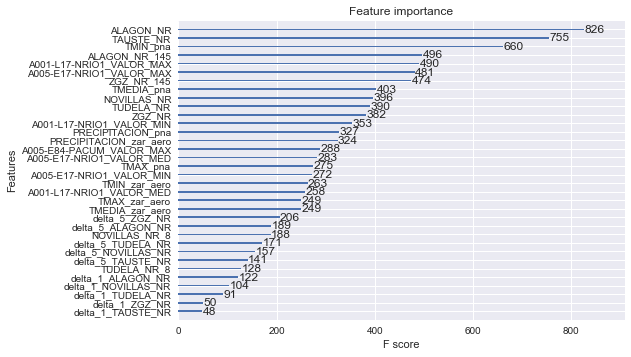

In [21]:
# plot feature importance
plot_importance(xgb)
plt.show()

### Cross-validation

In [22]:
kfold = KFold(n_splits=10, random_state=7)
scoring = 'r2'
scores = cross_val_score(regr, X, Y, cv=kfold, scoring=scoring)
print('Accuracy: %0.2f (+/- %0.2f)' % (scores.mean()*100.0, scores.std()*100.0))

Accuracy: 86.55 (+/- 6.81)


In [23]:
xgb = xgboost.XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=7)

scores = cross_val_score(xgb, X, Y, cv=kfold, scoring=scoring)
print('Accuracy: %0.2f (+/- %0.2f)' % (scores.mean()*100.0, scores.std()*100.0))
print('Confidence interval 66%')
print('Accuracy: %0.2f (+/- %0.2f)' % (scores.mean()*100.0, scores.std()*100.0 * 2))
print('Confidence interval 95%')
print('Accuracy: %0.2f (+/- %0.2f)' % (scores.mean()*100.0, scores.std()*100.0 * 2.6))
print('Confidence interval 99%')

Accuracy: 88.24 (+/- 5.86)
Confidence interval 66%
Accuracy: 88.24 (+/- 11.71)
Confidence interval 95%
Accuracy: 88.24 (+/- 15.23)
Confidence interval 99%


## Feature selection <a class="anchor" id="fourth-bullet"></a>

In [24]:
from sklearn.feature_selection import SelectFromModel

xgb.fit(x_train, y_train)

# Fit model using each importance as a threshold\n",
thresholds = np.unique(np.sort(xgb.feature_importances_))

# Fit model using each importance as a threshold
for thresh in thresholds:
    # select features using threshold
    selection = SelectFromModel(xgb, threshold=thresh, prefit=True)
    select_x = selection.transform(X)
    
    # train model
    selection_model = xgboost.XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,
                                           colsample_bytree=1, max_depth=7)
    
    scores = cross_val_score(selection_model, select_x, Y, cv=kfold, scoring=scoring)
    
    # eval model
    print("Thresh=%.3f, n=%d, Accuracy: %0.2f (+/- %0.2f)" % (thresh, select_x.shape[1], 
                                                              scores.mean()*100.0, 
                                                              scores.std()*100.0 * 2))

Thresh=0.005, n=34, Accuracy: 88.24 (+/- 11.71)
Thresh=0.005, n=33, Accuracy: 88.01 (+/- 12.07)
Thresh=0.009, n=32, Accuracy: 88.13 (+/- 11.82)
Thresh=0.010, n=31, Accuracy: 88.24 (+/- 11.13)
Thresh=0.012, n=30, Accuracy: 88.17 (+/- 11.22)
Thresh=0.012, n=29, Accuracy: 88.20 (+/- 11.09)
Thresh=0.013, n=28, Accuracy: 88.25 (+/- 10.91)
Thresh=0.015, n=27, Accuracy: 88.43 (+/- 10.35)
Thresh=0.016, n=26, Accuracy: 88.33 (+/- 10.95)
Thresh=0.018, n=25, Accuracy: 88.12 (+/- 11.10)
Thresh=0.018, n=24, Accuracy: 88.20 (+/- 10.96)
Thresh=0.020, n=23, Accuracy: 88.05 (+/- 11.34)
Thresh=0.024, n=22, Accuracy: 87.86 (+/- 11.39)
Thresh=0.025, n=20, Accuracy: 87.66 (+/- 11.43)
Thresh=0.025, n=19, Accuracy: 87.90 (+/- 12.00)
Thresh=0.026, n=18, Accuracy: 87.92 (+/- 11.00)
Thresh=0.026, n=17, Accuracy: 87.69 (+/- 12.22)
Thresh=0.027, n=16, Accuracy: 87.77 (+/- 11.67)
Thresh=0.027, n=15, Accuracy: 88.11 (+/- 10.69)
Thresh=0.031, n=14, Accuracy: 88.14 (+/- 10.01)
Thresh=0.031, n=13, Accuracy: 87.78 (+/-